<a href="https://colab.research.google.com/github/neeraja-04/CURVETOPIA/blob/main/Curvetopia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing necessary Libraries

In [10]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

Preprocessing the image

In [11]:
def preprocess_image(image_path, threshold_value=127):
    # Load the image and convert it to grayscale
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply a binary threshold to the grayscale image
    _, binary_threshold = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(binary_threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    return img, gray, contours

Name the image

In [12]:
def annotate_image(img, text, center, color=(0, 0, 0), offset=(0, 0)):
    cv2.putText(img, text, (center[0] + offset[0], center[1] + offset[1]),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

Function to detect shape

In [26]:
def detect_shapes(image, contours):
    # Find the bounding box of the entire image
    outermost_contour = max(contours, key=cv2.contourArea)

    for contour in contours:
        # Skip the outermost contour (bounding box)
        if np.array_equal(contour, outermost_contour):
            continue

        approx = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True)
        cv2.drawContours(image, [contour], 0, (0, 0, 255), 5)

        M = cv2.moments(contour)
        if M['m00'] == 0.0:
            continue

        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        num_vertices = len(approx)
        shape_text = ""

        if num_vertices == 3:
            shape_text = "Triangle"
        elif num_vertices == 4:
            x, y, w, h = cv2.boundingRect(approx)
            aspectRatio = float(w) / h
            shape_text = "Square" if 0.95 <= aspectRatio <= 1.05 else "Rectangle"
        elif num_vertices == 5:
            shape_text = "Pentagon"
        elif num_vertices == 6:
            shape_text = "Hexagon"
        elif num_vertices == 7:
            shape_text = "Heptagon"
        elif num_vertices == 8:
            shape_text = "Octagon"
        elif num_vertices == 9:
            shape_text = "Nonagon"
        elif num_vertices == 10:
            if cv2.isContourConvex(approx):
                shape_text = "Decagon"
            else:
                shape_text = "Star"
        else:
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            if perimeter == 0:
                continue
            circularity = 4 * np.pi * (area / (perimeter ** 2))
            if 0.89 <= circularity <= 1 and num_vertices > 6:
                shape_text = "Circle"
            else:
                shape_text = "Other"

        annotate_image(image, shape_text, (cx, cy))

Function to detect Symmetry

In [14]:
def detect_symmetry(image, gray, contours):
    vertical_img = image.copy()
    horizontal_img = image.copy()
    diagonal1_img = image.copy()
    diagonal2_img = image.copy()

    for contour in contours:
        if len(contour) < 5:
            continue

        M = cv2.moments(contour)
        if M['m00'] == 0:
            continue

        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        x, y, w, h = cv2.boundingRect(contour)
        center_x = x + w // 2
        center_y = y + h // 2

        mask = np.zeros_like(gray)
        cv2.drawContours(mask, [contour], -1, 255, -1)

        def check_symmetry(mask, flip_func):
            roi_mask = mask[y:y+h, x:x+w]
            flipped_mask = flip_func(roi_mask)
            if flipped_mask.shape != roi_mask.shape:
                flipped_mask = cv2.resize(flipped_mask, (roi_mask.shape[1], roi_mask.shape[0]))
            similarity = np.sum(roi_mask == flipped_mask) / (w * h)
            return similarity

        vertical_similarity = check_symmetry(mask, np.fliplr)
        horizontal_similarity = check_symmetry(mask, np.flipud)
        diagonal_similarity_1 = check_symmetry(mask, lambda m: np.transpose(m))
        diagonal_similarity_2 = check_symmetry(mask, lambda m: np.transpose(np.fliplr(m)))

        symmetry_threshold = 0.75

        if vertical_similarity > symmetry_threshold:
            annotate_image(vertical_img, 'Vertical Symmetry', (cx, cy), color=(0, 0, 255))
            cv2.line(vertical_img, (center_x, y), (center_x, y + h), (255, 0, 0), 2)

        if horizontal_similarity > symmetry_threshold:
            annotate_image(horizontal_img, 'Horizontal Symmetry', (cx, cy), color=(0, 255, 0), offset=(0, 20))
            cv2.line(horizontal_img, (x, center_y), (x + w, center_y), (0, 255, 0), 2)

        if diagonal_similarity_1 > symmetry_threshold:
            annotate_image(diagonal1_img, 'Diagonal Symmetry 1', (cx, cy), color=(255, 255, 0), offset=(0, 40))
            cv2.line(diagonal1_img, (x, y), (x + w, y + h), (255, 255, 0), 2)

        if diagonal_similarity_2 > symmetry_threshold:
            annotate_image(diagonal2_img, 'Diagonal Symmetry 2', (cx, cy), color=(0, 255, 255), offset=(0, 60))
            cv2.line(diagonal2_img, (x, y + h), (x + w, y), (0, 255, 255), 2)

    return vertical_img, horizontal_img, diagonal1_img, diagonal2_img

Display images

In [20]:
def display_image(img, title="Image"):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

**DETECTING AND DISPLAYING SYMMETRY IN REGULAR SHAPES**

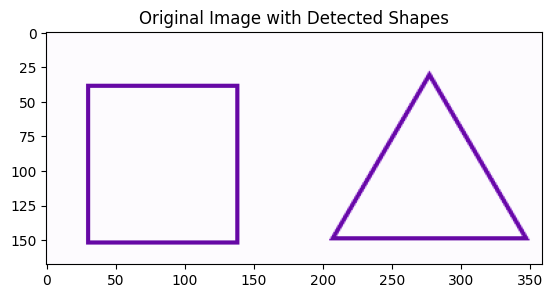

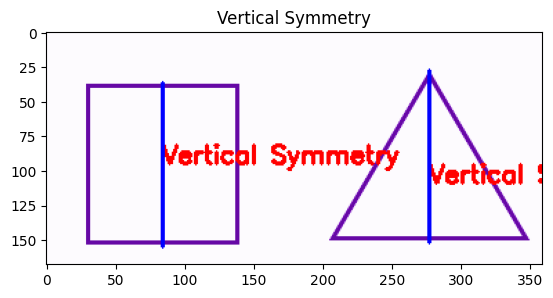

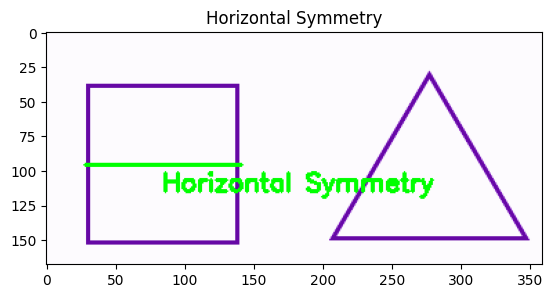

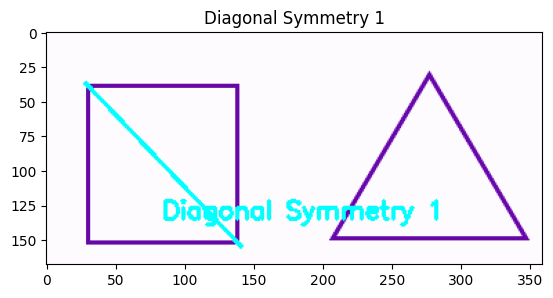

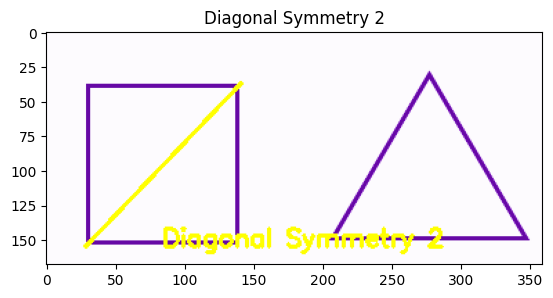

In [51]:
image_path = './Images/sample1.png'
img, gray, contours = preprocess_image(image_path)

vertical_img, horizontal_img, diagonal1_img, diagonal2_img = detect_symmetry(img, gray, contours)

display_image(img, "Original Image with Detected Shapes")
display_image(vertical_img, "Vertical Symmetry")
display_image(horizontal_img, "Horizontal Symmetry")
display_image(diagonal1_img, "Diagonal Symmetry 1")
display_image(diagonal2_img, "Diagonal Symmetry 2")

**Detect and display shapes in the original image**

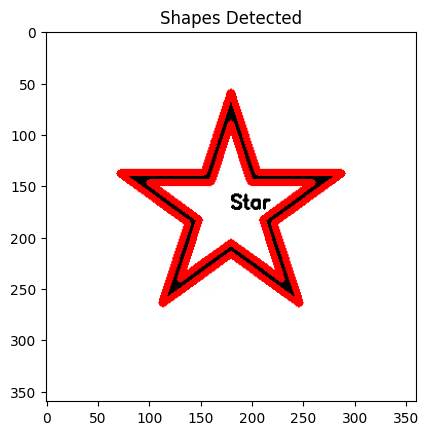

In [50]:
image_path = './Images/star.jpg'
img, gray, contours = preprocess_image(image_path)

detect_shapes(img, contours)
display_image(img, "Shapes Detected")

**Regularizing curves**

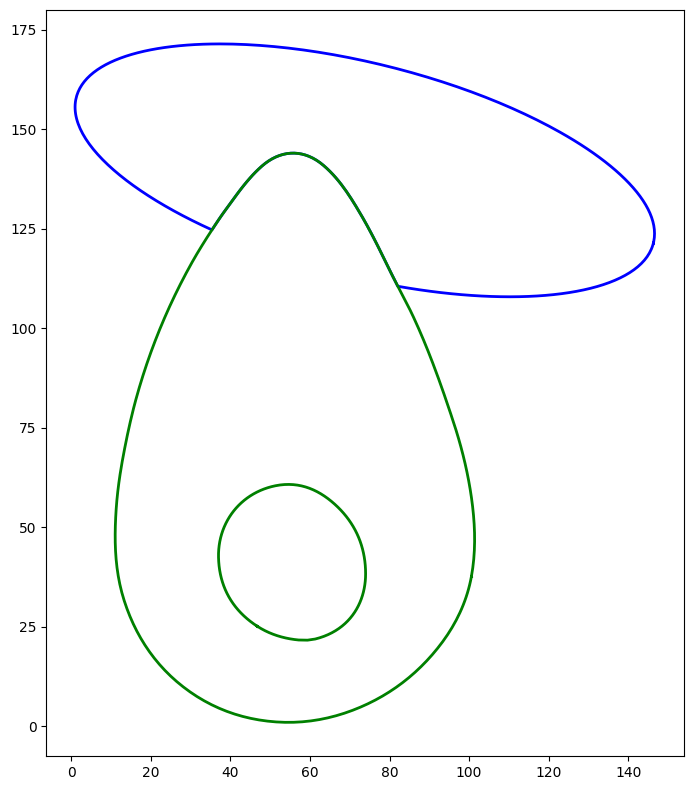

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import svgwrite
import cairosvg

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []

    # Iterate through unique path IDs (first column)
    for path_id in np.unique(np_path_XYs[:, 0]):
        path_data = np_path_XYs[np_path_XYs[:, 0] == path_id]
        XYs = []

        # Iterate through unique sub-path IDs (second column)
        for sub_id in np.unique(path_data[:, 1]):
            XY = path_data[path_data[:, 1] == sub_id][:, 2:]
            XYs.append(XY)

        path_XYs.append(XYs)

    return path_XYs

def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']

    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)

    ax.set_aspect('equal')
    plt.show()

def polylines2svg(paths_XYs, svg_path):
    W, H = 0, 0
    colours = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']

    # Calculate the maximum width and height
    for path_XYs in paths_XYs:
        for XY in path_XYs:
            W = max(W, np.max(XY[:, 0]))
            H = max(H, np.max(XY[:, 1]))

    # Adding padding
    padding = 0.1
    W, H = int(W * (1 + padding)), int(H * (1 + padding))

    # Create a new SVG drawing
    dwg = svgwrite.Drawing(svg_path, profile='tiny', size=(W, H), shape_rendering='crispEdges')
    group = dwg.g()

    for i, path in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in path:
            path_d = [("M", (XY[0, 0], XY[0, 1]))] + [("L", (x, y)) for x, y in XY[1:]]
            path_str = " ".join(f"{cmd} {x},{y}" for cmd, (x, y) in path_d)
            group.add(dwg.path(d=path_str, fill='none', stroke=c, stroke_width=2))

    dwg.add(group)
    dwg.save()

    # Convert SVG to PNG
    png_path = svg_path.replace('.svg', '.png')
    fact = max(1, 1024 // min(H, W))

    cairosvg.svg2png(url=svg_path, write_to=png_path, parent_width=W, parent_height=H,
                     output_width=fact * W, output_height=fact * H, background_color='white')

    return

def regularize_curves(paths_XYs):
    # Placeholder for future regularization logic
    return paths_XYs

def explore_symmetry(paths_XYs):
    # Placeholder for future symmetry exploration logic
    return paths_XYs

def complete_curves(paths_XYs):
    # Placeholder for future curve completion logic
    return paths_XYs

# Path to the CSV file
csv_path = './problems/occlusion1.csv'

# Read the CSV and process the data
paths_XYs = read_csv(csv_path)

# Regularize curves
regularized_paths = regularize_curves(paths_XYs)

# Explore symmetry

# Visualize the result
plot(regularized_paths)

# Convert to SVG and PNG
polylines2svg(regularized_paths, 'output.svg')